In [84]:
# !pip install tensorboardX
# !pip install bound-propagation


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('../hw2/mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('../hw2/mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN with three activation layers
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,10)

    def forward(self, x):
        # x = (x - 0.1307)/0.3081  # Normalize input
        x = x.view((-1, 28*28))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x


# Implement Bound Model

In [ ]:
from bound_propagation import BoundModule, IntervalBounds

class BoundNet(BoundModule):
    def __init__(self, model, factory, **kwargs):
        super().__init__(model, factory, **kwargs)
        self.fc1 = factory.build(model.fc1)
        self.relu1 = factory.build(nn.ReLU())
        self.fc2 = factory.build(model.fc2)
        self.relu2 = factory.build(nn.ReLU())
        self.fc3 = factory.build(model.fc3)
        self.relu3 = factory.build(nn.ReLU())
        self.fc4 = factory.build(model.fc4)

    def propagate_size(self, in_size):
        # We have to flatten the input here to match the first linear layer
        size = (in_size[0], 784)
        size = self.fc1.propagate_size(size)
        size = self.relu1.propagate_size(size)
        size = self.fc2.propagate_size(size)
        size = self.relu2.propagate_size(size)
        size = self.fc3.propagate_size(size)
        size = self.relu3.propagate_size(size)
        size = self.fc4.propagate_size(size)
        return size

    def ibp_forward(self, bounds, save_relaxation=False, save_input_bounds=False):
        # Again have to flatten the bounds to match the first linear layer
        lower = bounds.lower.view(bounds.lower.size(0), -1)
        upper = bounds.upper.view(bounds.upper.size(0), -1)
        bounds = IntervalBounds(bounds.region, lower, upper)

        bounds = self.fc1.ibp_forward(bounds, save_relaxation, save_input_bounds)
        bounds = self.relu1.ibp_forward(bounds, save_relaxation, save_input_bounds)
        bounds = self.fc2.ibp_forward(bounds, save_relaxation, save_input_bounds)
        bounds = self.relu2.ibp_forward(bounds, save_relaxation, save_input_bounds)
        bounds = self.fc3.ibp_forward(bounds, save_relaxation, save_input_bounds)
        bounds = self.relu3.ibp_forward(bounds, save_relaxation, save_input_bounds)
        bounds = self.fc4.ibp_forward(bounds, save_relaxation, save_input_bounds)
        return bounds

    @property
    def need_relaxation(self):
        # Not needed for ibp
        raise NotImplementedError()

    def clear_relaxation(self):
        # Not needed for ibp
        raise NotImplementedError()

    def backward_relaxation(self, region):
        # Not needed for ibp
        raise NotImplementedError()

    def crown_backward(self, linear_bounds, optimize):
        # Not needed for ibp
        raise NotImplementedError()

# Training

In [ ]:
from contextlib import nullcontext
from bound_propagation import HyperRectangle, BoundModelFactory
from tqdm import trange
import os

def train(model, method='ibp', num_epochs=10):
    print('')
    print('[TRAINING]')

    model.train()

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    k = 1.0
    k_step = (k-0.5)/num_epochs
    eps = 0.00
    eps_step = (0.1-eps)/num_epochs
    for epoch in trange(num_epochs):
        running_loss = 0.0
        for i, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            output = model(X)
            cross_entropy = criterion(output, y)

            if method == 'ibp' and k < 1.0:
                bounds = model.ibp(HyperRectangle.from_eps(X, eps))
                adv_logit = adversarial_logit(bounds, y)
                loss = k * cross_entropy + (1 - k) * criterion(adv_logit, y)
            else:
                loss = cross_entropy

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # print every 100 mini-batches
                print(f'\r[{epoch + 1}, {i + 1:3d}] loss: {running_loss / 100:.3f}', end='')
                running_loss = 0.0

        k = max(k - k_step, 0.5)
        eps = min(eps + eps_step, 0.1)
    
    
    if not os.path.exists('models'):
        os.makedirs('models')
    torch.save(model.state_dict(), f"models/{method}_model.pth")


def test(model, method='pgd'):
    print('\nTesting with method:', method)

    # We can save time with no_grad if not attacking with PGD
    context = torch.no_grad() if method == 'standard' else nullcontext()
    with context:
        correct = 0
        total = 0
        for i, (X, y) in enumerate(test_loader):
            X, y = X.to(device), y.to(device)
            if method == 'pgd':
                X = pgd_linf_untargeted(model, X, y, k=5, eps=0.1, eps_step=0.1/4)
            outputs = model(X)
            predicted = torch.argmax(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        print(f'Accuracy on images: {100 * correct / total}')


def adversarial_logit(y_hat, y):
    batch_size = y.size(0)
    classes = torch.arange(10, device=y.device).unsqueeze(0).expand(batch_size, -1)
    mask = (classes == y.unsqueeze(-1)).to(dtype=y_hat.lower.dtype)

    # Take upper bound for logit of all but the correct class where you take the lower bound
    adversarial_logit = (1 - mask) * y_hat.upper + mask * y_hat.lower

    return adversarial_logit


def pgd_linf_untargeted(model, x, labels, k, eps, eps_step):
    ce_loss = torch.nn.CrossEntropyLoss()
    adv_x = x.clone().detach()
    adv_x.requires_grad_(True) 

    for _ in range(k):
        adv_x = adv_x.requires_grad_(True)
        model.zero_grad()
        output = model(adv_x)

        # Calculate the loss
        loss = ce_loss(output, labels)
        loss.backward()

        # compute the adv_x
        # find delta, clamp with eps
        signed_grad = torch.sign(adv_x.grad)
        adv_x = adv_x.detach() + eps_step * signed_grad
        adv_x = torch.clamp(adv_x, x-eps, x+eps)
        adv_x = torch.clamp(adv_x, 0, 1)

    return adv_x

# Intialize models

In [ ]:
model = Net()
model = model.to(device)
train(model, method='standard', num_epochs=10)


[TRAINING]


  0%|          | 0/10 [00:00<?, ?it/s]

[1, 900] loss: 0.303

 10%|█         | 1/10 [00:06<00:59,  6.59s/it]

[2, 900] loss: 0.225

 20%|██        | 2/10 [00:12<00:51,  6.41s/it]

[3, 900] loss: 0.190

 30%|███       | 3/10 [00:19<00:44,  6.36s/it]

[4, 900] loss: 0.149

 40%|████      | 4/10 [00:25<00:38,  6.35s/it]

[5, 900] loss: 0.129

 50%|█████     | 5/10 [00:33<00:34,  6.95s/it]

[6, 900] loss: 0.115

 60%|██████    | 6/10 [00:39<00:27,  6.78s/it]

[7, 900] loss: 0.101

 70%|███████   | 7/10 [00:46<00:19,  6.65s/it]

[8, 900] loss: 0.103

 80%|████████  | 8/10 [00:52<00:13,  6.62s/it]

[9, 900] loss: 0.083

 90%|█████████ | 9/10 [00:59<00:06,  6.61s/it]

[10, 900] loss: 0.068

100%|██████████| 10/10 [01:07<00:00,  6.76s/it]


In [113]:
model = Net()
model = model.to(device)

factory = BoundModelFactory()
factory.register(Net, BoundNet)
bound_model = factory.build(model)
train(bound_model, method='ibp', num_epochs=10)


[TRAINING]


  0%|          | 0/10 [00:00<?, ?it/s]

[1, 900] loss: 0.304

 10%|█         | 1/10 [00:06<00:59,  6.57s/it]

[2, 900] loss: 0.355

 20%|██        | 2/10 [00:23<01:40, 12.52s/it]

[3, 900] loss: 0.361

 30%|███       | 3/10 [00:38<01:35, 13.62s/it]

[4, 900] loss: 0.374

 40%|████      | 4/10 [00:56<01:31, 15.30s/it]

[5, 900] loss: 0.418

 50%|█████     | 5/10 [01:10<01:14, 14.93s/it]

[6, 900] loss: 0.480

 60%|██████    | 6/10 [01:25<01:00, 15.07s/it]

[7, 900] loss: 0.509

 70%|███████   | 7/10 [01:38<00:43, 14.39s/it]

[8, 900] loss: 0.595

 80%|████████  | 8/10 [01:53<00:29, 14.54s/it]

[9, 900] loss: 0.666

 90%|█████████ | 9/10 [02:06<00:14, 14.19s/it]

[10, 900] loss: 0.736

100%|██████████| 10/10 [02:20<00:00, 14.03s/it]


In [111]:
model.load_state_dict(torch.load('models/standard_model.pth'))
test(model, method='standard')
test(model, method='pgd')


Testing with method: standard
Accuracy on images: 97.06

Testing with method: pgd
Accuracy on images: 2.34


In [114]:
bound_model.load_state_dict(torch.load('models/ibp_model.pth'))
test(bound_model, method='standard')
test(bound_model, method='pgd')


Testing with method: standard
Accuracy on images: 92.95

Testing with method: pgd
Accuracy on images: 81.05


# Box Verification

In [126]:
# Perfom ibp analysis
# Loop over different epsilon values
import collections


verified_example_indexes = []
unverified_example_indexes = collections.defaultdict(list)

for i in range(1, 11):
    eps = i * 0.01
    verified_count = 0
    total_count = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get input and output bounds with current epsilon
        input_bounds = HyperRectangle.from_eps(images, eps)
        output_bounds = bound_model.ibp(input_bounds)

        # Loop through each sample in the batch to verify robustness
        for batch_idx, true_class in enumerate(labels):
            lower = output_bounds.lower[batch_idx]
            upper = output_bounds.upper[batch_idx]

            # Check if lower bound of true class is greater than upper bounds of all other classes
            other_start = upper[:true_class]
            other_end = upper[true_class+1:]
            max_other = torch.max(torch.cat((other_start, other_end)))
            if lower[true_class] > max_other:
                verified_count += 1
                verified_example_indexes.append(total_count)
            else:
                unverified_example_indexes[round(eps, 2)].append(total_count)

            total_count += 1

    verified_accuracy = 100 * verified_count / total_count
    print(f"Verified accuracy with eps={eps:.2f}: {verified_count}/{total_count} ({verified_accuracy:.2f}%)")

Verified accuracy with eps=0.01: 9130/10000 (91.30%)
Verified accuracy with eps=0.02: 8966/10000 (89.66%)
Verified accuracy with eps=0.03: 8774/10000 (87.74%)
Verified accuracy with eps=0.04: 8539/10000 (85.39%)
Verified accuracy with eps=0.05: 8281/10000 (82.81%)
Verified accuracy with eps=0.06: 8007/10000 (80.07%)
Verified accuracy with eps=0.07: 7670/10000 (76.70%)
Verified accuracy with eps=0.08: 7288/10000 (72.88%)
Verified accuracy with eps=0.09: 6804/10000 (68.04%)
Verified accuracy with eps=0.10: 6258/10000 (62.58%)


Adversarial images with eps: 0.01


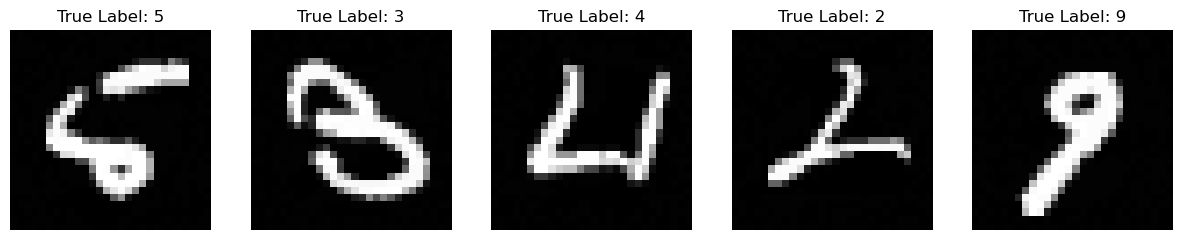

Adversarial images with eps: 0.02


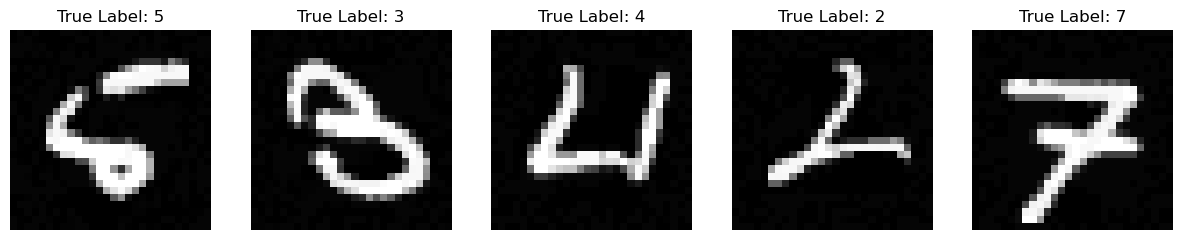

Adversarial images with eps: 0.03


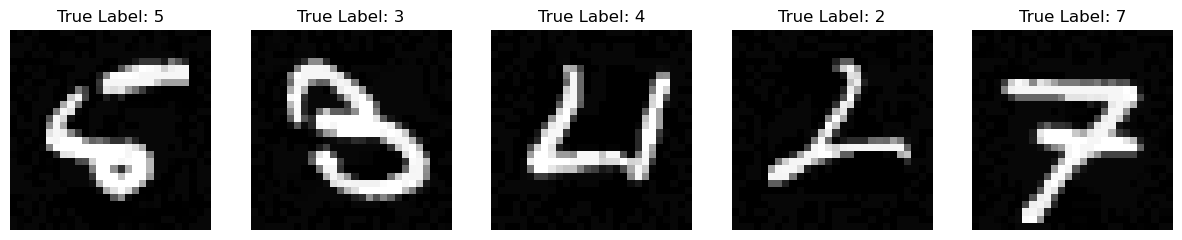

Adversarial images with eps: 0.04


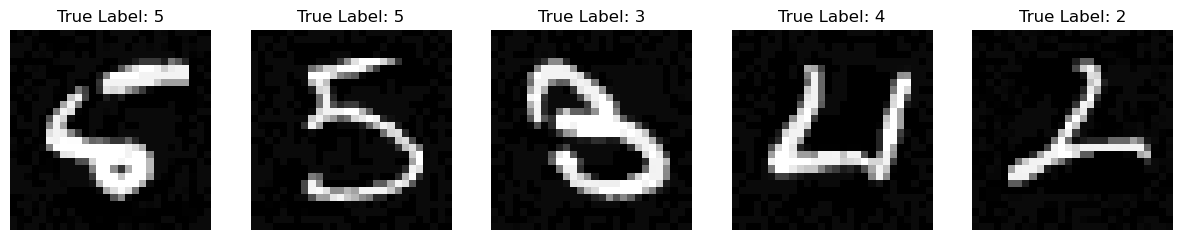

Adversarial images with eps: 0.05


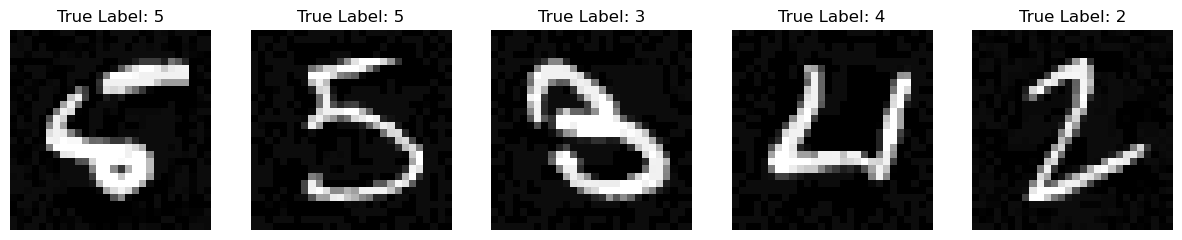

Adversarial images with eps: 0.06


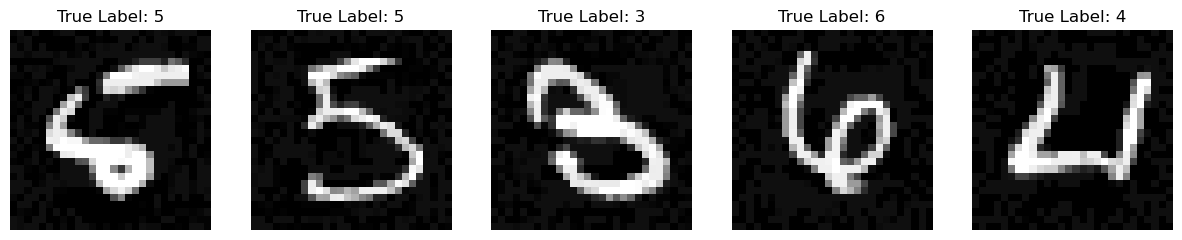

Adversarial images with eps: 0.07


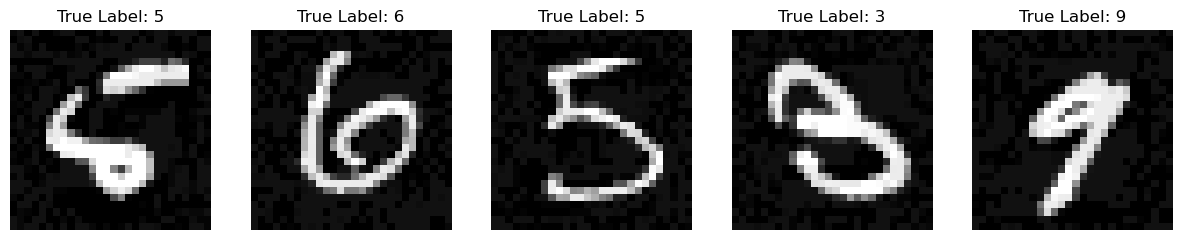

Adversarial images with eps: 0.08


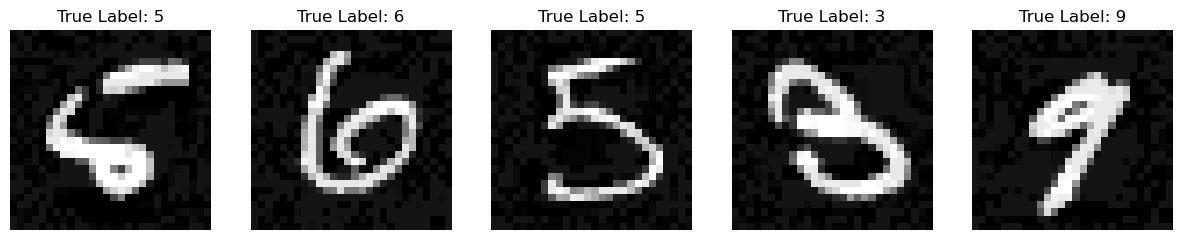

Adversarial images with eps: 0.09


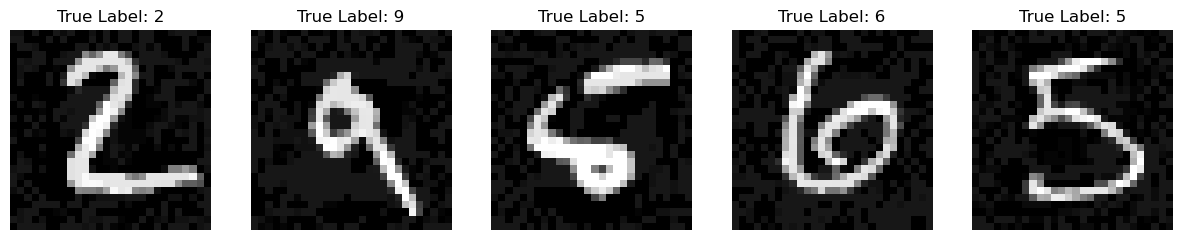

Adversarial images with eps: 0.10


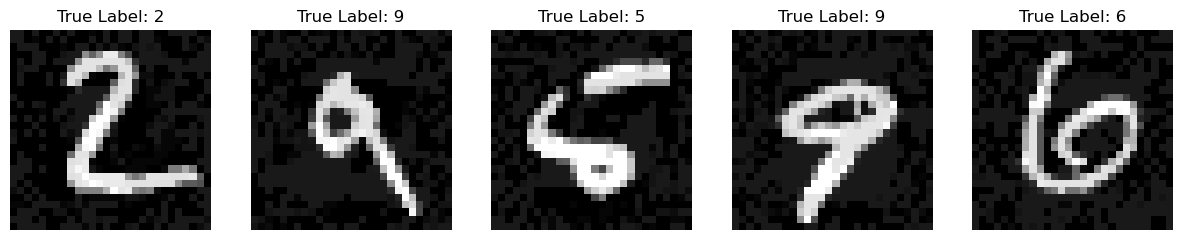

In [141]:
import matplotlib.pyplot as plt

for i in range(1, 11):
    # Display the first 5 unverified examples with eps 0.01 to 0.1
    eps = round(i * 0.01, 2)
    print(f"Adversarial images with eps: {eps:.2f}")
    img_indexes = unverified_example_indexes[eps][:5]

    imgs = []
    labels = []

    for idx in img_indexes:
        img, label = test_dataset[idx]
        imgs.append(img)
        labels.append(label)

    img_batch = torch.stack(imgs).to(device)
    label_batch = torch.tensor(labels).to(device)
    adv_batch = pgd_linf_untargeted(bound_model, img_batch, label_batch, k=5, eps=eps, eps_step=eps/4)

    plt.figure(figsize=(15,3))
    for j, adv_example in enumerate(adv_batch):
        plt.subplot(1, 5, j+1)

        # Display the image
        plt.imshow(adv_example.squeeze().detach().cpu(), cmap='gray')
        plt.title(f"True Label: {labels[j]}")
        plt.axis('off')
    plt.show()